In [260]:
import os
import cv2
import numpy as np
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt
from collections import Counter
import torch
from torchvision import models, transforms
from PIL import Image
import scipy.io as sio
from sklearn.metrics import f1_score
import pandas as pd
import random
import matplotlib.patches as mpatches 

In [261]:
import ssl
ssl._create_default_https_context = ssl._create_stdlib_context

In [262]:
segment_length = 60 
# num_clusters = 15
# num_key_clusters = 15
sampling_every_ith_frame = 20
similarity_threshold = 0.5
input_dir = "../vidvrd-dataset/SumMe"
output_dir = './vidvrd-dataset/SumMeResults/'
debugging = False

In [263]:
device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))
print(f"Using device: {device}")

# Load pre-trained ResNet50
model = models.resnet50(weights='ResNet50_Weights.DEFAULT') 

# Remove classification layer
model = torch.nn.Sequential(*list(model.children())[:-1]) 
model.to(device) 
model.eval()  # Set to evaluation mode

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Using device: cpu


In [264]:
def load_summe_data(dataset_path):
    """
    Loads the SumMe dataset from its original structure.

    Args:
        dataset_path (str): Path to the SumMe dataset directory.

    Returns:
        data (dict): Dictionary mapping video names to their data, where each video's data is a dictionary containing:
            - 'video_path': Path to the video file.
            - 'gt_summary': List of lists, each representing a ground truth summary as frame indices (starting from 1).
    """
    video_dir = os.path.join(dataset_path, "videos")
    gt_dir = os.path.join(dataset_path, "GT")

    data = {}
    for filename in os.listdir(gt_dir):
        if filename.endswith(".mat"):
            video_name = filename[:-4]  # Remove .mat extension
            video_path = os.path.join(video_dir, video_name + ".mp4")
            
            gt_data = sio.loadmat(os.path.join(gt_dir, filename))

            # Extract and normalize ground truth summaries to 0-based indexing
            gt_summary = gt_data['user_score']
            gt_summary = (gt_summary > 0).astype(int) # Convert to binary
            orig_orig_gt = gt_summary.copy()

            # Downsample gt_summary and replicate for each user
            downsampled_gt_summary = []
            for i in range(0, len(gt_summary), segment_length):
                
                # Count the number of 1s in the interval
                num_keyframes = np.sum(gt_summary[i:i + segment_length], axis=0)
                # Convert to binary based on whether there are at least 2 keyframes
                downsampled_gt_summary.append((num_keyframes >= 1).astype(int)) 

            # Reshape to match the original user_score dimensions
            downsampled_gt_summary = np.array(downsampled_gt_summary)

            # print(orig_gt_summary_segment_relavent)
            
            data[video_name] = {
                'video_path': video_path,
                'gt_summary': downsampled_gt_summary,
                # 'orig_gt_summary_segment_relavent': orig_gt_summary_segment_relavent,
                'orig_gt_summary': orig_orig_gt
            }
    return data

In [265]:
def extract_embeddings(frames, model, preprocess, device):
    embeddings = []
    for frame in frames:
        # frame_tensor = preprocess(torch.from_numpy(frame)).unsqueeze(0).to(device)
        with torch.no_grad():
            embedding = model(frame)
        embedding = embedding.cpu().squeeze().numpy()
        embeddings.append(embedding.astype('double'))
    return embeddings

In [266]:
def process_video_frames(frames, frame_indices):
    """
    Processes video frames, extracts features, clusters, and returns selected keyframes.

    Args:
        frames (list): List of video frames (as numpy arrays).
        frame_indices (list): Corresponding frame indices in the original video.

    Returns:
        list: Indices of the selected keyframes within the original video.
    """

    if len(frames) - 1 < num_clusters:
        print(f"Not enough frames for clustering (found {len(frames)}, need at least {num_clusters})")
        return frame_indices  # Return all frame indices if too few frames

    # Compute embeddings for each frame
    embeddings = extract_embeddings(frames, model, preprocess, device)

    # Flatten embeddings and cluster
    flattened_embeddings = np.concatenate([embedding.reshape(1, -1) for embedding in embeddings], axis=0)
    spectral_cluster = SpectralClustering(n_clusters=num_clusters, affinity='nearest_neighbors', n_neighbors=num_clusters).fit(flattened_embeddings)
    embedding_clusters = spectral_cluster.labels_
    
    # Select keyframes (one from each cluster)
    selected_keyframe_indices = []
    for cluster_idx in range(num_clusters):
        cluster_frame_indices = [i for i, label in enumerate(embedding_clusters) if label == cluster_idx]
        if cluster_frame_indices: # If cluster not empty

            cluster_embeddings = np.array([embedding for i, embedding in enumerate(embeddings) if i in cluster_frame_indices])
            centroid = np.mean(cluster_embeddings, axis=0)  

            distances = [np.linalg.norm(embedding - centroid) for embedding in cluster_embeddings]
            closest_frame_idx_in_cluster = cluster_frame_indices[np.argmin(distances)]
            selected_keyframe_indices.append(closest_frame_idx_in_cluster) # Select the closest frame to the centroid
            # print('------- Cluster ' + str(cluster_idx) + ', keyframe indice = ' + str(closest_frame_idx_in_cluster)) 

    return selected_keyframe_indices


In [267]:
def calculate_f1_score(gt_summary, predicted_summary, segment_to_samping_ratio, print_result = False):
    """Calculates F1 score for a given video summary."""
    # Convert predicted summary to binary based on segment length
    predicted_summary_binary = np.zeros_like(gt_summary)
    for i in range(len(gt_summary)):
        start_index = i * segment_to_samping_ratio  # Start of the segment
        next_start_index = i * segment_to_samping_ratio + segment_to_samping_ratio  # End of the segment
        if(next_start_index > len(predicted_summary)):
            next_start_index = len(predicted_summary)
        # print(start_index, next_start_index)
        predicted_summary_binary[i] = np.any(predicted_summary[start_index:next_start_index])
    
 
    
    tp = np.sum(predicted_summary_binary * gt_summary)  # True positives
    fp = np.sum(predicted_summary_binary * (1 - gt_summary))  # False positives
    fn = np.sum((1 - predicted_summary_binary) * gt_summary)  # False negatives

    if print_result:
        print('Ground Truth:    ', gt_summary)
        print('Predicted Value: ', predicted_summary_binary)
        print(tp)
        print(fp)
        print(fn)
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    # print(precision)
    # print(recall)
    
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    return f1_score

In [268]:
def create_binary_array(indices, total_length):
    """Creates a binary NumPy array of given length with 1s at specified indices."""
    binary_array = np.zeros(total_length, dtype=int)  # Initialize with zeros
    binary_array[indices] = 1   # Set specified indices to 1
    return binary_array

def binary_array_to_indices(binary_array):
    """Converts a binary NumPy array to a list of indices where values are 1."""
    return np.where(binary_array == 1)[0].tolist()

In [269]:
def load_and_sample_video(video_path, sampling_every_ith_frame):
    """
    Loads a video, samples frames, and determines the number of clusters using VSUMM's approach.

    Args:
        video_path (str): Path to the video file.
        sampling_rate (int): Sample every ith frame

    Returns:
        sampled_frames (list): List of sampled video frames (as PyTorch tensors).
        frame_indices (list): Corresponding frame indices in the original video.
        num_clusters (int): Calculated number of clusters.
    """
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Sample frames and keep track of indices
    sampled_frames = []
    frame_indices = []

    # Preallocate a NumPy array to store histograms
    histograms = np.zeros((frame_count // sampling_every_ith_frame + 1, 16 * 16 * 16), dtype=np.float32)

    idx = 0
    for i in range(frame_count):
        ret, frame = cap.read()
        if ret and i % sampling_every_ith_frame == 0:  # Sample every 10th frame
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame_tensor = preprocess(Image.fromarray(frame)).unsqueeze(0).to(device) 
            # print(frame_tensor.size()) torch.Size([1, 3, 224, 224])
            sampled_frames.append(frame_tensor)
            frame_indices.append(i)

            # Extract HSV histogram from the frame
            hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
            hist = cv2.calcHist([hsv_frame], [0, 1, 2], None, [16, 16, 16], [0, 180, 0, 256, 0, 256])
            histograms[idx] = hist.flatten() 
            idx += 1
    
    # Vectorized Bhattacharyya distance calculation
    distances = [cv2.compareHist(histograms[i], histograms[i + 1], cv2.HISTCMP_BHATTACHARYYA)
                 for i in range(len(histograms) - 1)]

    # Dynamically determine the number of clusters (VSUMM approach)
    num_clusters = 1 + np.sum(np.array(distances) > similarity_threshold) 
    
    # Make sure at least two clusters
    num_clusters = max(4, num_clusters)

    return sampled_frames, frame_indices, num_clusters, frame_count

In [271]:
def display_frames(frames, frame_indices, frame_count, predicted_summary_original_indices, gt_summary_indices, video_name, output_dir, sampling_every_ith_frame, selected_user_idx):
    """Displays sampled frames in multiple grids of 10 frames each, highlighting keyframes, and saves them to files."""
    os.makedirs(output_dir, exist_ok=True)

    num_frames = len(frames)
    num_row = 5
    num_column = 8
    frames_per_plot = num_row * num_column

    for start_idx in range(0, num_frames, frames_per_plot):
        end_idx = start_idx + frames_per_plot # min(start_idx + frames_per_plot, num_frames)
        file_end_idx = min(start_idx + frames_per_plot, num_frames)

        # Create figure and axes for this set of frames
        fig, axes = plt.subplots(num_row, num_column, figsize=(24, 15))
        fig.suptitle(f"Video with: {video_name} with GT User Idx: {selected_user_idx}", fontsize=14)

        # print(predicted_summary_original_indices)
        # print(gt_summary_indices)

                # Create legend patches
        green_patch = mpatches.Patch(color=(0, 1, 0), label='Predicted Summary')  # RGB for green: (0, 255, 0)/255 = (0, 1, 0)
        blue_patch = mpatches.Patch(color='blue', label='Ground Truth Summary')

        # Iterate over the frames for this plot
        for idx in range(start_idx, end_idx):
            row = (idx - start_idx) // num_column
            col = (idx - start_idx) % num_column
            
             # If there are frames available, process them as before
            if idx < num_frames:
                frame_tensor = frames[idx]

                frame = frame_tensor.cpu().squeeze().permute(1, 2, 0).numpy()
                frame = (frame * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])) * 255
                frame = np.clip(frame, 0, 255).astype(np.uint8)
                original_frame_idx = frame_indices[idx]

                # Highlight predicted keyframes (green border)
                if original_frame_idx in predicted_summary_original_indices:
                    frame = cv2.copyMakeBorder(frame, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=(0, 255, 0))

                # Calculate start and end frame indices for the filename and title
                start_frame = original_frame_idx  # This is now the original frame index
                end_frame = min(original_frame_idx + sampling_every_ith_frame - 1, frame_count - 1)

                # Format filename and set title color
                filename = f"{video_name}_{start_frame:04d}"
                title_color = 'blue' if original_frame_idx in gt_summary_indices else 'black'  

            # If no more frames, create a white image
            else:
                frame = np.ones((224, 224, 3), dtype=np.uint8) * 255  # White image
                filename = "N/A"
                title_color = 'black'

            # Display frame in the subplot
            axes[row, col].imshow(frame)
            axes[row, col].set_title(filename, color=title_color)
            axes[row, col].axis('off')

        # Remove any remaining empty subplots
        for i in range(end_idx - start_idx, frames_per_plot):
            fig.delaxes(axes.flatten()[i])

        # Add legend to the plot
        plt.legend(handles=[green_patch, blue_patch], bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.tight_layout()

        # Create filename for the grid image
        grid_filename = f"{video_name}_{frame_indices[start_idx]:04d}_{frame_indices[file_end_idx - 1]:04d}_grid.jpg"

        if not debugging:
            plt.savefig(os.path.join(output_dir, grid_filename))
            plt.show()
            plt.close()  # Close the figure after saving
        else:
            plt.show()


In [273]:
def display_frames(frames, frame_indices, frame_count, predicted_summary_original_indices, gt_summary_indices, video_name, output_dir, sampling_every_ith_frame, selected_user_idx):
    """Displays sampled frames in multiple grids of 10 frames each, highlighting keyframes, and saves them to files."""
    os.makedirs(output_dir, exist_ok=True)

    num_frames = len(frames)
    num_row = 5
    num_column = 8
    frames_per_plot = num_row * num_column

    for start_idx in range(0, num_frames, frames_per_plot):
        end_idx = start_idx + frames_per_plot # min(start_idx + frames_per_plot, num_frames)
        file_end_idx = min(start_idx + frames_per_plot, num_frames)

        # Create figure and axes for this set of frames
        fig, axes = plt.subplots(num_row, num_column, figsize=(24, 15))
        fig.suptitle(f"Video with: {video_name} with GT User Idx: {selected_user_idx}", fontsize=16)

        fig.subplots_adjust(hspace=0.2, wspace=0.05) 

        # print(predicted_summary_original_indices)
        # print(gt_summary_indices)

                # Create legend patches
        green_patch = mpatches.Patch(color=(0, 1, 0), label='Predicted Summary')  # RGB for green: (0, 255, 0)/255 = (0, 1, 0)
        blue_patch = mpatches.Patch(color='blue', label='Ground Truth Summary')

        # Iterate over the frames for this plot
        for idx in range(start_idx, end_idx):
            row = (idx - start_idx) // num_column
            col = (idx - start_idx) % num_column
            
             # If there are frames available, process them as before
            if idx < num_frames:
                frame_tensor = frames[idx]

                frame = frame_tensor.cpu().squeeze().permute(1, 2, 0).numpy()
                frame = (frame * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])) * 255
                frame = np.clip(frame, 0, 255).astype(np.uint8)
                original_frame_idx = frame_indices[idx]

                # Highlight predicted keyframes (green border)
                if original_frame_idx in predicted_summary_original_indices:
                    frame = cv2.copyMakeBorder(frame, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=(0, 255, 0))

                # Calculate start and end frame indices for the filename and title
                start_frame = original_frame_idx  # This is now the original frame index
                end_frame = min(original_frame_idx + sampling_every_ith_frame - 1, frame_count - 1)

                # Format filename and set title color
                filename = f"{video_name}_{start_frame:04d}"
                title_color = 'blue' if original_frame_idx in gt_summary_indices else 'black'  

            # If no more frames, create a white image
            else:
                frame = np.ones((224, 224, 3), dtype=np.uint8) * 255  # White image
                filename = "N/A"
                title_color = 'black'

            # Display frame in the subplot
            axes[row, col].imshow(frame)
            axes[row, col].set_title(filename, color=title_color, fontsize=14)
            axes[row, col].axis('off')

        # Remove any remaining empty subplots
        for i in range(end_idx - start_idx, frames_per_plot):
            fig.delaxes(axes.flatten()[i])

        # Add legend to the plot
        legend = plt.legend(handles=[green_patch, blue_patch], bbox_to_anchor=(1.05, 1), loc='upper left')

        # Get legend bounding box in figure coordinates
        fig.canvas.draw()  # Render the figure to get accurate bounding box
        legend_bbox = legend.get_window_extent().transformed(fig.transFigure.inverted())

        # Add text above the legend
        text = f"Segment Length: {segment_length}\n" \
               f"Sampling: {sampling_every_ith_frame}\n" \
               f"Similarity Threshold: {similarity_threshold:.2f}"
        plt.text(legend_bbox.x0, legend_bbox.y1 + 0.01, text, color='black', fontsize=14,
                 verticalalignment='bottom', transform=fig.transFigure)

        # plt.tight_layout()

        # Create filename for the grid image
        grid_filename = f"{video_name}_{frame_indices[start_idx]:04d}_{frame_indices[file_end_idx - 1]:04d}_grid.jpg"

        if not debugging:
            plt.savefig(os.path.join(output_dir, grid_filename))
            plt.show()
            plt.close()  # Close the figure after saving
        else:
            plt.show()


In [274]:
def display_summary_frames(frames, frame_indices, frame_count, predicted_summary_original_indices,
                          gt_summary_indices, video_name, output_dir, sampling_every_ith_frame,
                          selected_user_idx, segment_length, similarity_threshold, debugging=False):
    """
    Displays sampled frames in multiple grids, highlighting keyframes, and saves them to files.
    This version only processes and displays frames with indices in predicted_summary_original_indices.
    Fills the last row with white images if there are not enough images.

    Args:
        frames (list): List of frame tensors.
        frame_indices (list): List of corresponding frame indices.
        frame_count (int): Total number of frames in the video.
        predicted_summary_original_indices (list): List of predicted summary frame indices.
        gt_summary_indices (list): List of ground truth summary frame indices.
        video_name (str): Name of the video.
        output_dir (str): Directory to save the output images.
        sampling_every_ith_frame (int): Sampling rate of frames.
        selected_user_idx (int): Index of the selected user (for title).
        segment_length (int): Length of each segment.
        similarity_threshold (float): Similarity threshold used for keyframe selection.
        debugging (bool, optional): Whether in debugging mode. Defaults to False.
    """
    os.makedirs(output_dir, exist_ok=True)

    predicted_summary_original_indices.sort()

    num_frames = len(predicted_summary_original_indices)  
    num_row = 5
    num_column = 8
    frames_per_plot = num_row * num_column
    summary_frame_count = 1

    for start_idx in range(0, num_frames, frames_per_plot):
        end_idx = min(start_idx + frames_per_plot, num_frames)

        fig, axes = plt.subplots(num_row, num_column, figsize=(24, 15))
        fig.suptitle(f"Summary Video: {video_name} with GT User Idx: {selected_user_idx}", fontsize=16)

        fig.subplots_adjust(hspace=0.2, wspace=0.05) 

        green_patch = mpatches.Patch(color=(0, 1, 0), label='Predicted Summary')
        blue_patch = mpatches.Patch(color='blue', label='Ground Truth Summary')

        # Iterate over all subplot positions
        for plot_idx, idx in enumerate(range(start_idx, frames_per_plot)):  
            row = plot_idx // num_column
            col = plot_idx % num_column

            if idx < end_idx:  # If there's a frame for this subplot
                original_frame_idx = predicted_summary_original_indices[idx]

                try:
                    frame_index_in_frames = frame_indices.index(original_frame_idx)
                    frame_tensor = frames[frame_index_in_frames]
                    frame = frame_tensor.cpu().squeeze().permute(1, 2, 0).numpy()
                    frame = (frame * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])) * 255
                    frame = np.clip(frame, 0, 255).astype(np.uint8)

                    frame = cv2.copyMakeBorder(frame, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=(0, 255, 0))

                    start_frame = original_frame_idx  
                    end_frame = min(original_frame_idx + sampling_every_ith_frame - 1, frame_count - 1)

                    filename = f"{video_name}_{start_frame:04d}"
                    title_color = 'blue' if original_frame_idx in gt_summary_indices else 'black'

                except ValueError:
                    print(f"Warning: Index {original_frame_idx} not found in frame_indices.")
                    frame = np.ones((224, 224, 3), dtype=np.uint8) * 255
                    filename = "N/A"
                    title_color = 'black'

                axes[row, col].imshow(frame)
                axes[row, col].set_title(filename, color=title_color, fontsize=14)
                axes[row, col].axis('off')

            else:  # Fill with white image if no more frames
                frame = np.ones((224, 224, 3), dtype=np.uint8) * 255
                axes[row, col].imshow(frame)
                axes[row, col].axis('off') 

        # Add legend to the plot
        legend = plt.legend(handles=[green_patch, blue_patch], bbox_to_anchor=(1.05, 1), loc='upper left')

        # Get legend bounding box in figure coordinates
        fig.canvas.draw() 
        legend_bbox = legend.get_window_extent().transformed(fig.transFigure.inverted())

        # Add text above the legend
        text = f"Segment Length: {segment_length}\n" \
               f"Sampling: {sampling_every_ith_frame}\n" \
               f"Similarity Threshold: {similarity_threshold:.2f}"
        plt.text(legend_bbox.x0, legend_bbox.y1 + 0.01, text, color='black', fontsize=14,
                 verticalalignment='bottom', transform=fig.transFigure)

        # plt.tight_layout()

        # Create filename for the grid image
        grid_filename = f"Summary video: {video_name}_{summary_frame_count}.jpg"
        summary_frame_count += 1

        if not debugging:
            plt.savefig(os.path.join(output_dir, grid_filename))
            plt.show()
            plt.close() 
        else:
            plt.show()

In [275]:
def calculate_orig_gt_summary_segment_relavent(orig_gt_summary_indices, selected_user_idx, segment_length, sampling_every_ith_frame):
    # Find indices of sampled frames that ground truth segment covers
    orig_gt_summary_segment = list( set( [ int(i/segment_length) * segment_length for i in orig_gt_summary_indices ] ) )
    num_segments = int(segment_length / sampling_every_ith_frame)

    orig_gt_summary_segment_relavent = []
    for num in orig_gt_summary_segment:
        orig_gt_summary_segment_relavent.extend([num + (i * sampling_every_ith_frame) for i in range(num_segments)])
        
    return orig_gt_summary_segment_relavent


num_key_clusters:  5
num_frames:  64


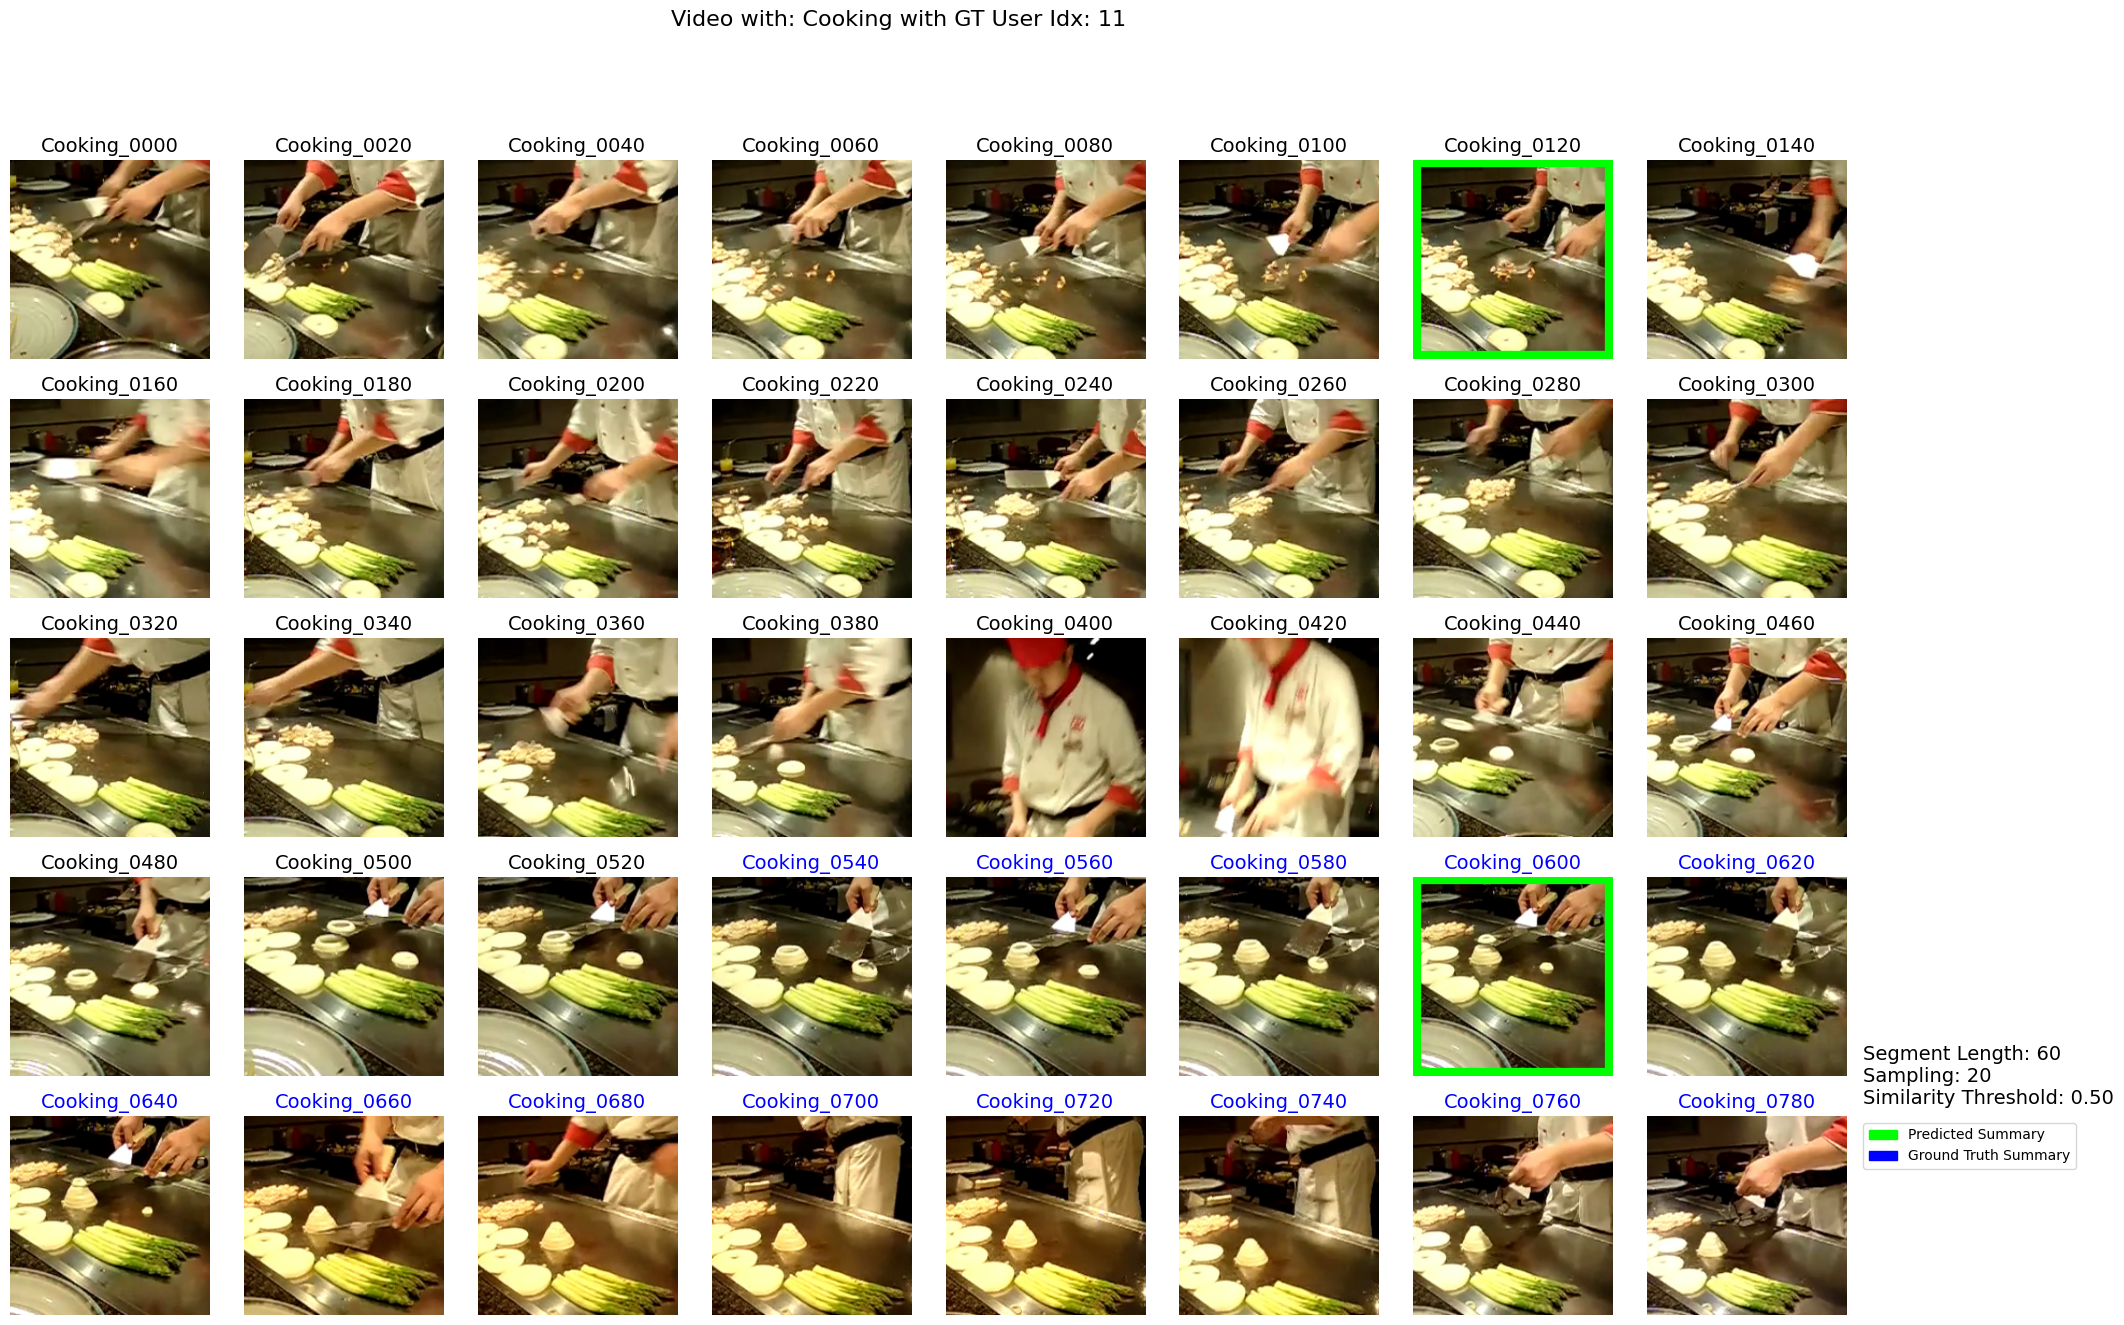

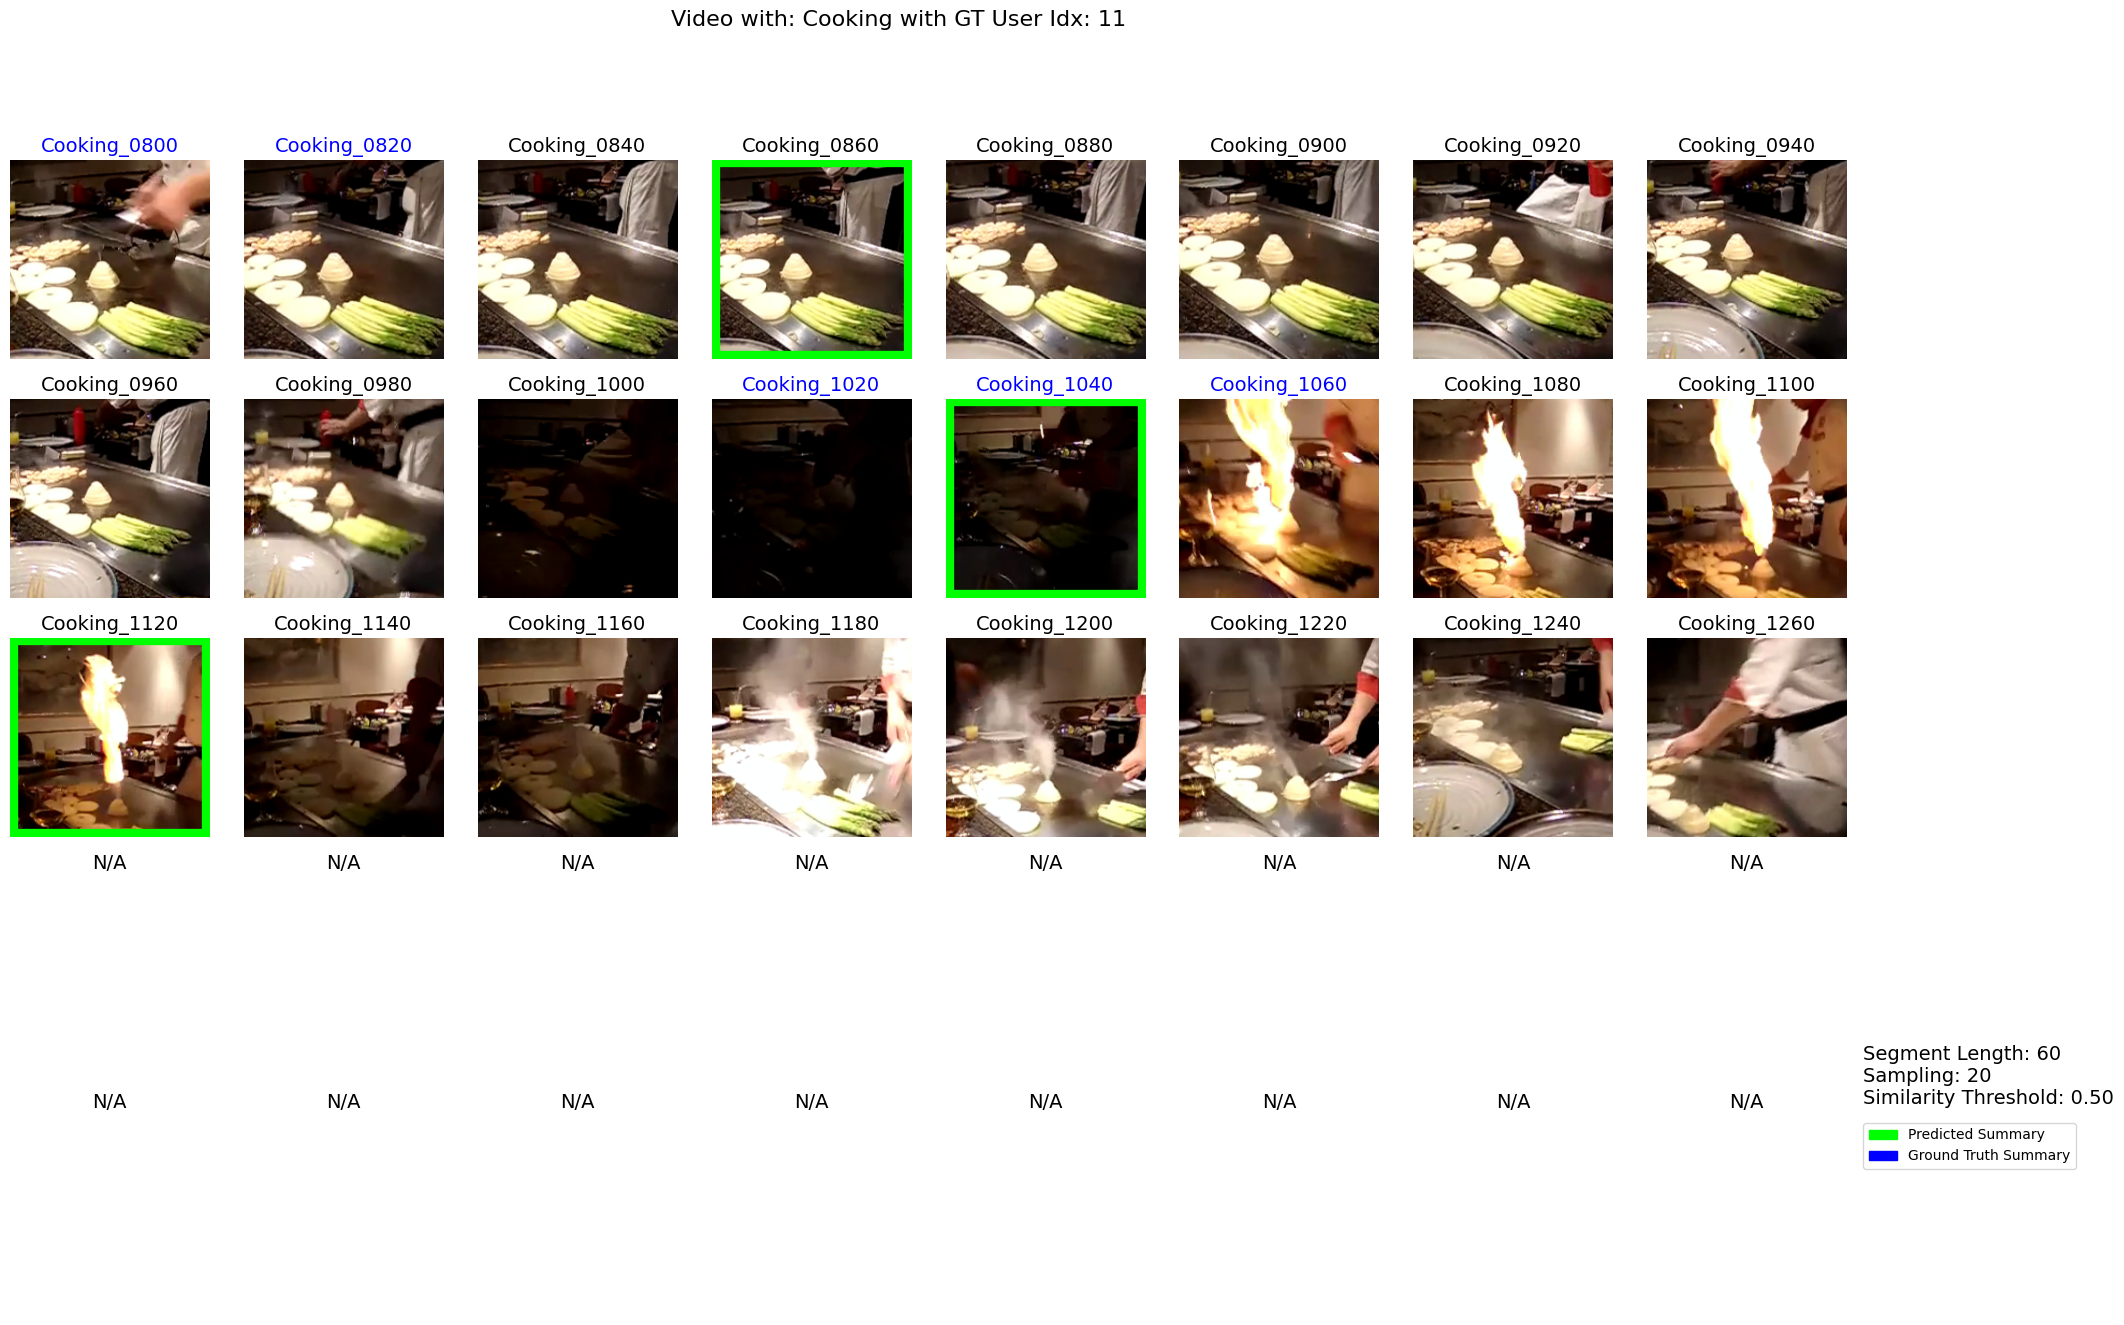

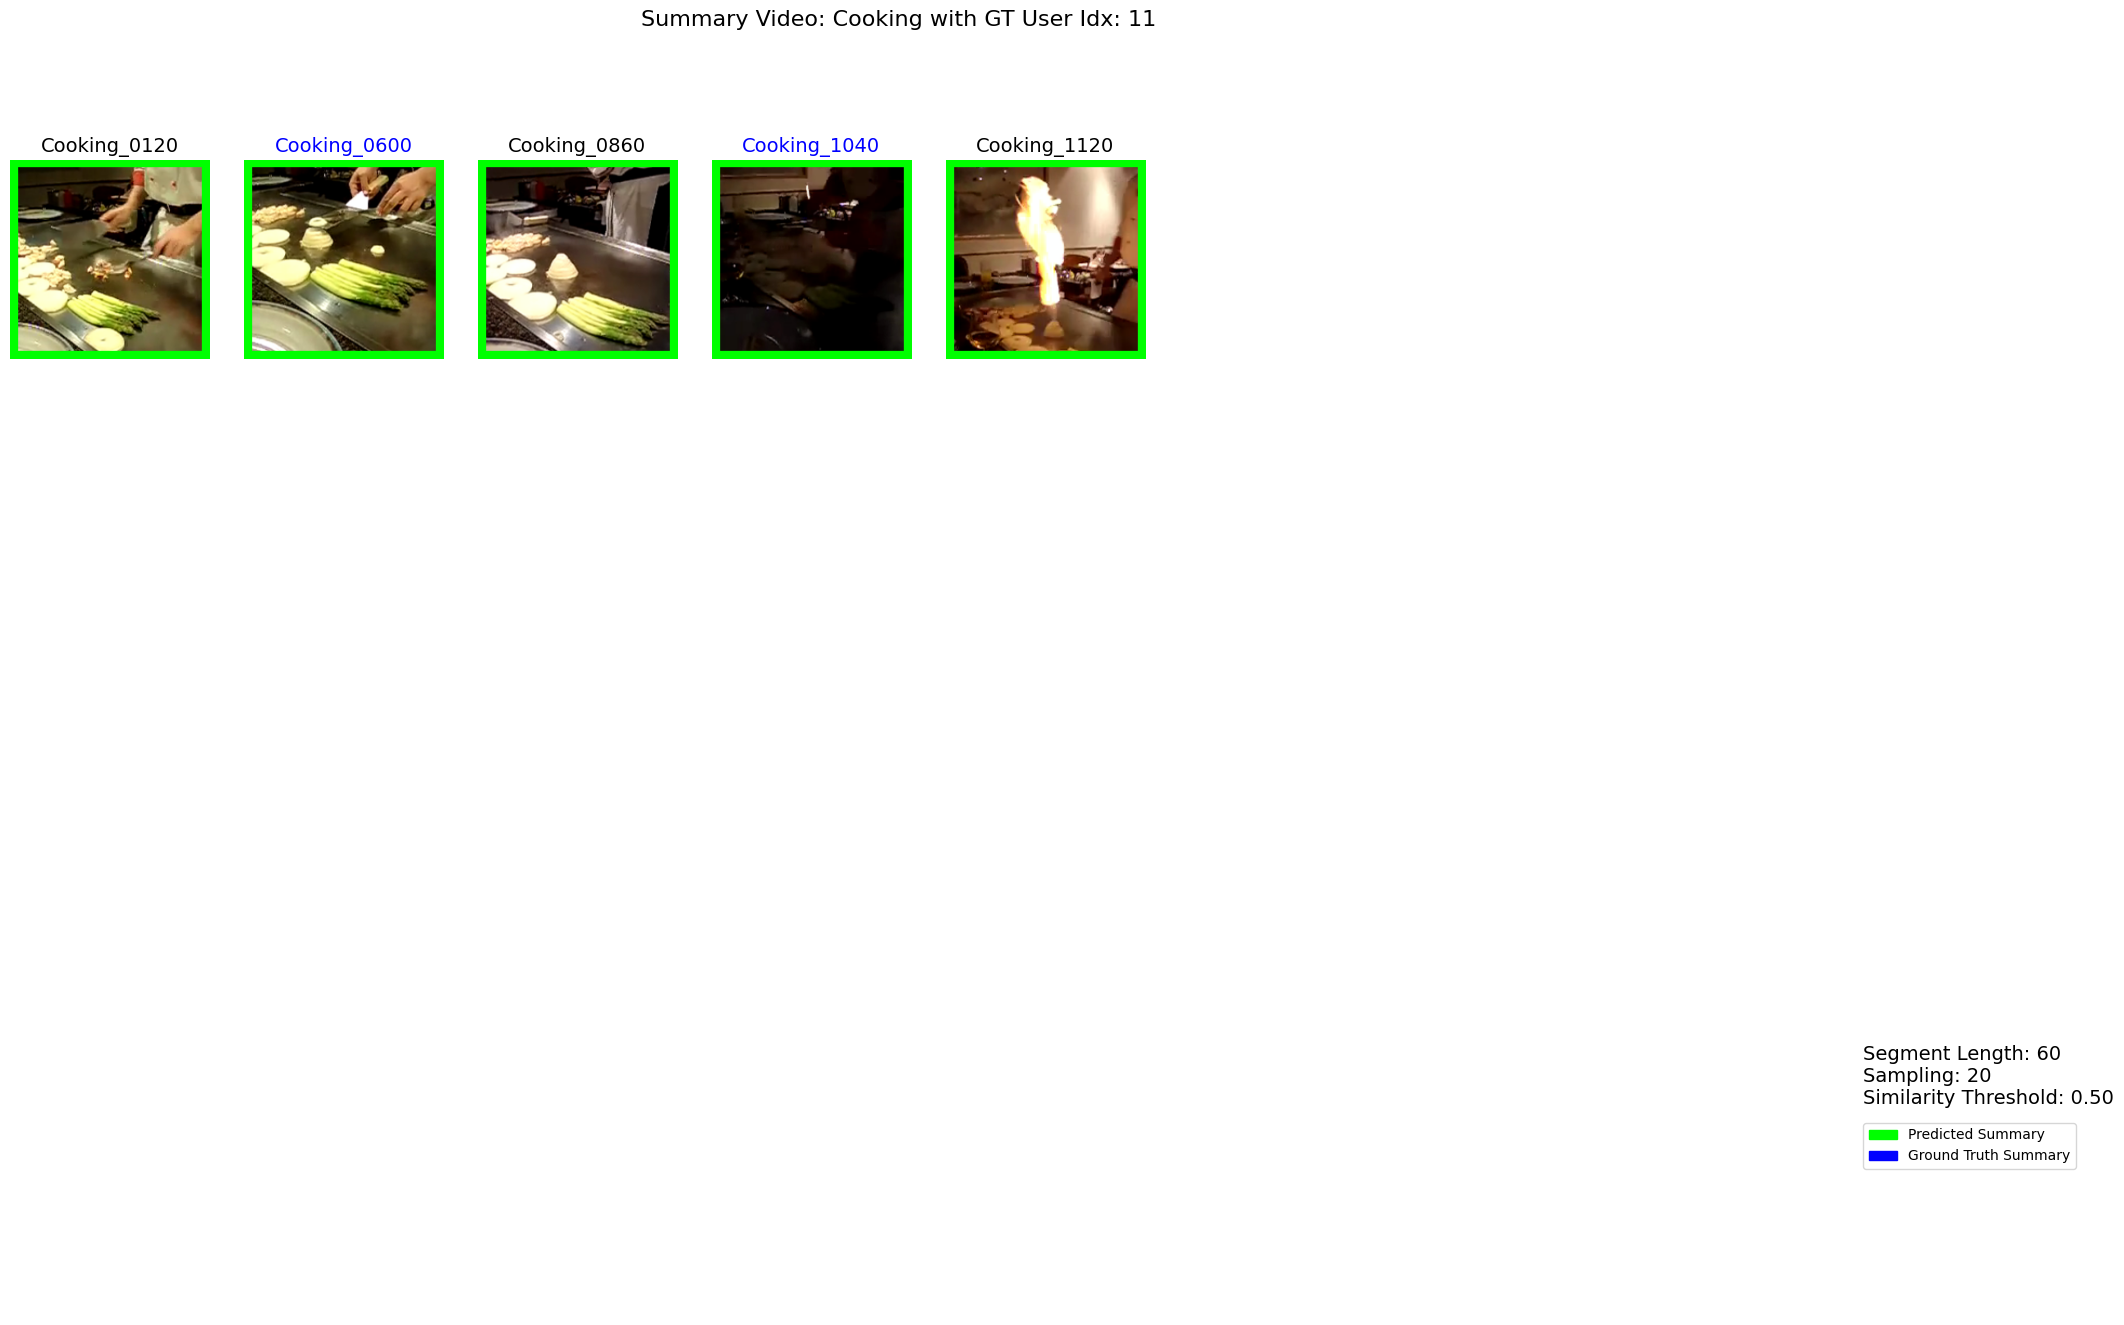

segment_length:  60
sampling_every_ith_frame:  20
similarity_threshold:  0.5
| Video   | F1 Score   |
|:--------|:-----------|
| Cooking | 0.360122   |

Overall Average F1 Score: 0.3601



In [276]:
data = load_summe_data(input_dir)

video_names = []
average_f1_scores = []

# Loop over videos and calculate F1 score
for video_name, video_data in data.items():
    if video_name != 'Cooking':
        continue
    video_path = video_data['video_path']
    gt_summary = video_data['gt_summary']
    orig_gt_summary = video_data['orig_gt_summary']

    # Use for display
    num_users = len(gt_summary[0])
    selected_user_idx = random.randint(0, num_users - 1)
    selected_user_idx = 11

    # 1. Load video and perform pre-sampling of frames and keep track of indices
    sampled_frames, frame_indices, num_clusters, frame_count = load_and_sample_video(video_path, sampling_every_ith_frame)
    num_key_clusters = num_clusters
    print("num_key_clusters: ", num_key_clusters)
    print("num_frames: ", len(sampled_frames))

    # 3. Clustering 
    predicted_summary_indices = process_video_frames(sampled_frames, frame_indices)
    # predicted_summary_indices =  [i * sampling_every_ith_frame for i in predicted_summary_indices] # Convert back to original indices

    predicted_summary_indices_format = create_binary_array(predicted_summary_indices, len(gt_summary) * int(segment_length / sampling_every_ith_frame)) 

    # 4. Calculate F1 Score
    f1_scores = []
    
    for i in range(len(gt_summary[0])):
        f1 = calculate_f1_score(gt_summary[:,i], predicted_summary_indices_format, int(segment_length / sampling_every_ith_frame) ) # selected_user_idx == i
        f1_scores.append(f1)
        # print(f"Video: {video_name}, F1 Score: {f1}")
    average_f1 = sum(f1_scores) / len(f1_scores)

    video_names.append(video_name)
    average_f1_scores.append(average_f1)

    # 5. Display frames
    predicted_summary_original_indices = [indice * sampling_every_ith_frame for indice in predicted_summary_indices]
    
    orig_gt_summary_indices = binary_array_to_indices(orig_gt_summary[:,selected_user_idx])
    orig_gt_summary_segment_relavent = calculate_orig_gt_summary_segment_relavent(orig_gt_summary_indices, selected_user_idx, segment_length, sampling_every_ith_frame)

    display_frames(sampled_frames, frame_indices, frame_count, predicted_summary_original_indices, orig_gt_summary_segment_relavent, video_name, output_dir, sampling_every_ith_frame, selected_user_idx)
    display_summary_frames(sampled_frames, frame_indices, frame_count, predicted_summary_original_indices, orig_gt_summary_segment_relavent, video_name, output_dir, sampling_every_ith_frame, selected_user_idx, segment_length, similarity_threshold)


print("segment_length: ", segment_length)
print("sampling_every_ith_frame: ", sampling_every_ith_frame)
print("similarity_threshold: ", similarity_threshold)
    
# Create the table for all results
df = pd.DataFrame({'Video': video_names, 'F1 Score': average_f1_scores})
print(df.to_markdown(index=False, numalign='left', stralign='left'))

overall_average_f1 = df['F1 Score'].mean()
print(f"\nOverall Average F1 Score: {overall_average_f1:.4f}\n")